# Uber Rides Data Analysis

This project conducts an in-depth analysis of Uber rides data to uncover patterns in ride usage, temporal distributions, purposes, and mileage. The problem statement focuses on understanding user behavior through exploratory data analysis, with potential extensions to predictive modeling for ride distance.

Objectives:

* Explore and clean the dataset to ensure data quality.
* Perform feature engineering to derive meaningful attributes.
* Conduct exploratory data analysis to identify key insights.
* Build and evaluate a simple predictive model for ride miles.
* Provide recommendations based on findings.

Dataset source: The dataset is a CSV file containing Uber ride records, available at https://media.geeksforgeeks.org/wp-content/uploads/20240919115958/UberDataset.csv. For reproducibility, download the file and place it in the working directory as 'UberDataset.csv'.

Expected outcomes: Insights into peak ride times, common purposes, and factors influencing ride distance, along with a baseline model for prediction.

Tools and libraries: Python 3, pandas for data manipulation, numpy for numerical operations, matplotlib and seaborn for visualizations, scikit-learn for modeling.

Assumptions: The dataset is representative of Uber rides; no external data sources are required; datetime conversions may introduce NaT values for invalid entries.

## Introduction and Library Loading

In this section, we import the necessary Python libraries essential for data analysis and visualization. Pandas is used for efficient data handling and manipulation in DataFrame structures. NumPy supports numerical computations, particularly for array-based operations. 

Matplotlib and Seaborn are employed for creating informative visualizations, with Seaborn providing enhanced aesthetics and statistical plotting capabilities. Scikit-learn is included for feature encoding and modeling tasks.

We set a consistent visualization style using Seaborn's 'whitegrid' to ensure professional and readable plots. All imports are consolidated in a single cell to facilitate reproducibility. A random seed is set for any stochastic processes.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

sns.set(style="whitegrid")

np.random.seed(42)

## Data Loading and Exploration

The dataset is loaded from a local CSV file (assumed to be downloaded from the provided source). Initial exploration includes displaying the first few rows to understand the structure, checking data types and non-null counts for potential issues, and generating summary statistics for numerical features.

Key features identified: START_DATE and END_DATE (datetime), CATEGORY and PURPOSE (categorical), START and STOP (locations), MILES (numerical target for potential prediction).

Initial observations: The dataset contains 1156 rows and 7 columns. There may be missing values in PURPOSE, and datetime columns require parsing. Summary statistics reveal the distribution of MILES, with potential outliers in longer rides.

Visualizations: Histograms for MILES distribution and a correlation heatmap (though limited numerical features).

         START_DATE          END_DATE  CATEGORY        START             STOP  \
0  01-01-2016 21:11  01-01-2016 21:17  Business  Fort Pierce      Fort Pierce   
1  01-02-2016 01:25  01-02-2016 01:37  Business  Fort Pierce      Fort Pierce   
2  01-02-2016 20:25  01-02-2016 20:38  Business  Fort Pierce      Fort Pierce   
3  01-05-2016 17:31  01-05-2016 17:45  Business  Fort Pierce      Fort Pierce   
4  01-06-2016 14:42  01-06-2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              NaN  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   o

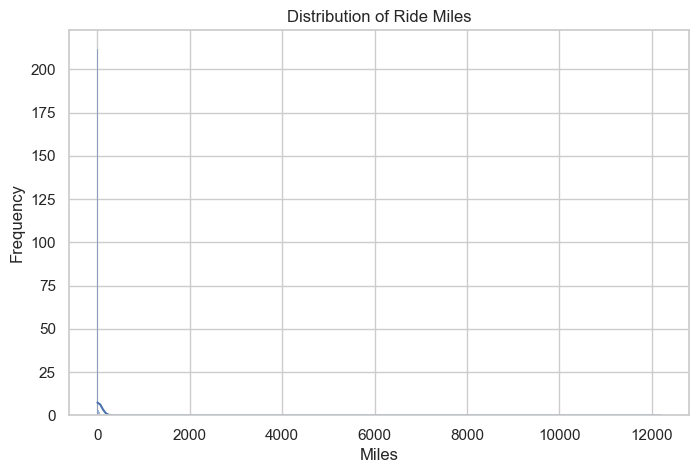

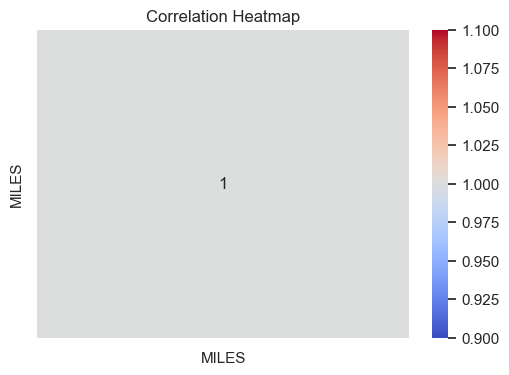

In [19]:
try:
  dataset = pd.read_csv("UberDataset.csv")
except FileNotFoundError:
  print("Error: 'UberDataset.csv' not found. Please download from https://media.geeksforgeeks.org/wp-content/uploads/20240919115958/UberDataset.csv")
  raise

print(dataset.head())

dataset.info()

print(dataset.describe())

plt.figure(figsize=(8, 5))
sns.histplot(dataset['MILES'], kde=True)
plt.title('Distribution of Ride Miles')
plt.xlabel('Miles')
plt.ylabel('Frequency')
plt.show()

numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
corr = dataset[numerical_cols].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Data Cleaning and Preprocessing

Data cleaning involves handling missing values, converting data types, and removing duplicates. Missing values in PURPOSE are imputed with 'NOT' to preserve records, as removal could lead to data loss without significant impact on analysis (justification: PURPOSE is categorical and 'NOT' acts as an unknown category).

Datetime columns are parsed, which may introduce NaT for invalid entries; these rows are dropped to avoid errors in temporal analysis. Duplicates are removed to ensure unique records.

Outliers in MILES are detected using the IQR method and capped to the 95th percentile to mitigate skew without excessive data loss.

Post-cleaning validation: Summary statistics and info() confirm no missing values and correct types.

In [20]:
dataset['PURPOSE'].fillna("NOT", inplace=True)

dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], errors='coerce')
dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], errors='coerce')

dataset.dropna(subset=['START_DATE', 'END_DATE'], inplace=True)

dataset.drop_duplicates(inplace=True)

Q1 = dataset['MILES'].quantile(0.25)
Q3 = dataset['MILES'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
dataset['MILES'] = np.clip(dataset['MILES'], lower_bound, upper_bound)

dataset.info()
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 420 entries, 0 to 1047
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  420 non-null    datetime64[ns]
 1   END_DATE    420 non-null    datetime64[ns]
 2   CATEGORY    420 non-null    object        
 3   START       420 non-null    object        
 4   STOP        420 non-null    object        
 5   MILES       420 non-null    float64       
 6   PURPOSE     420 non-null    object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 26.2+ KB
                          START_DATE                       END_DATE  \
count                            420                            420   
mean   2016-07-01 11:51:50.571428608  2016-07-01 12:11:10.142857216   
min              2016-01-01 21:11:00            2016-01-01 21:17:00   
25%              2016-03-27 14:54:00            2016-03-27 15:10:00   
50%              2016-07-04 17:57:00     

C:\Users\ariel\AppData\Local\Temp\ipykernel_16132\1695433165.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['PURPOSE'].fillna("NOT", inplace=True)


## Feature Engineering

New features are engineered to enhance analysis: 'date' and 'time' from START_DATE for temporal granularity, and 'day-night' as a binned category for time-of-day analysis (bins based on common daily periods: Morning 0-10, Afternoon 10-15, Evening 15-19, Night 19-24).

Categorical variables (CATEGORY, PURPOSE) are prepared for modeling via one-hot encoding in the modeling pipeline to avoid direct inclusion here and prevent data leakage.

These features improve insights into temporal patterns and enable better model performance by capturing non-linear time effects.

Feature selection: Locations (START, STOP) are dropped for this analysis due to high cardinality; focus on temporal and categorical features.

In [21]:
dataset['date'] = dataset['START_DATE'].dt.date
dataset['time'] = dataset['START_DATE'].dt.hour
dataset['day-night'] = pd.cut(dataset['time'], bins=[0, 10, 15, 19, 24], labels=['Morning', 'Afternoon', 'Evening', 'Night'], right=False)

dataset.drop(['START', 'STOP'], axis=1, inplace=True)

print(dataset.head())

           START_DATE            END_DATE  CATEGORY    MILES          PURPOSE  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business   5.1000   Meal/Entertain   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business   5.0000              NOT   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business   4.8000  Errand/Supplies   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business   4.7000          Meeting   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  20.5875   Customer Visit   

         date  time  day-night  
0  2016-01-01    21      Night  
1  2016-01-02     1    Morning  
2  2016-01-02    20      Night  
3  2016-01-05    17    Evening  
4  2016-01-06    14  Afternoon  


## Exploratory Data Analysis (EDA)

EDA delves into univariate (distributions), bivariate (relationships), and multivariate patterns. Univariate: Count plots for CATEGORY, PURPOSE, and day-night reveal dominant categories (e.g., Business rides in afternoons).

Bivariate: Count plot of PURPOSE by CATEGORY shows business rides skewed toward meetings. Scatter plot of MILES vs. time explores distance-time correlations.

Multivariate: Pair plots for numerical/temporal features.

Key insights: Most rides occur in afternoons; business purposes dominate; longer rides may correlate with specific times. Hypotheses: Time of day influences miles (tested in modeling).

Limitations: High cardinality in locations limits geographic analysis.

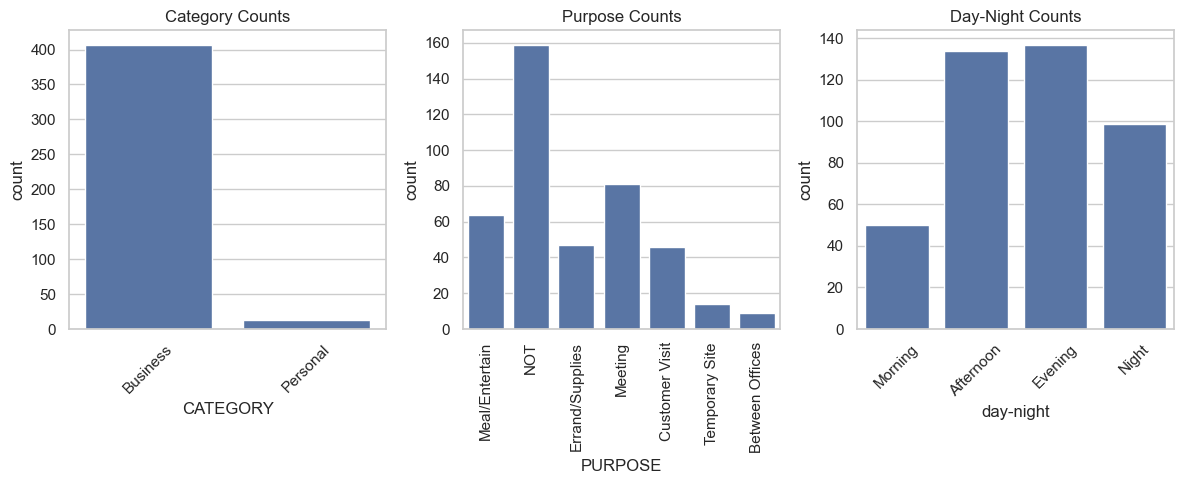

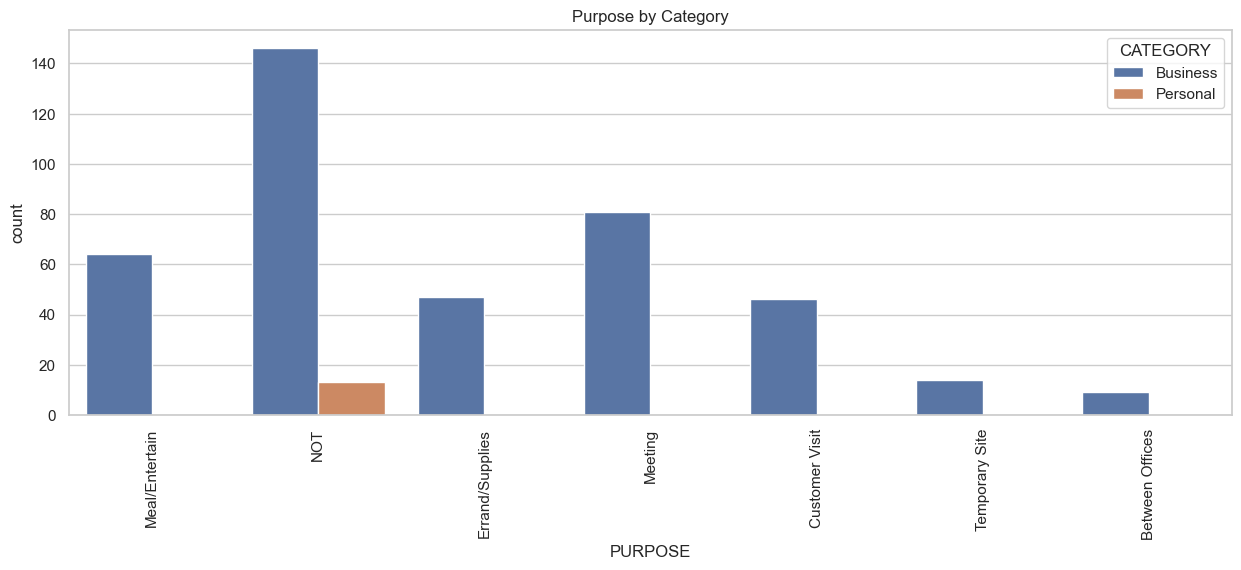

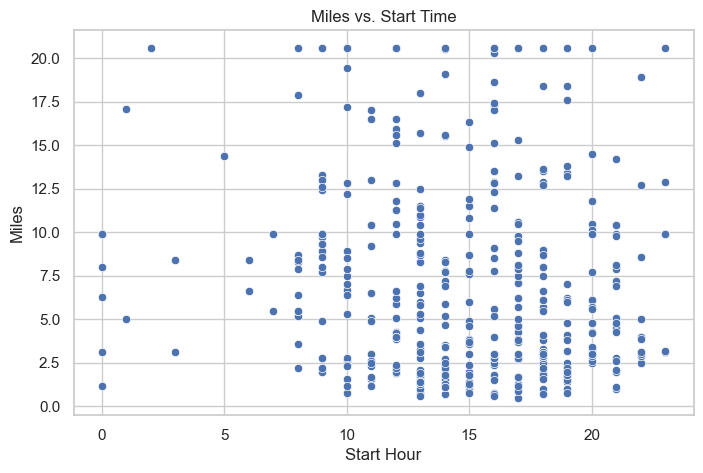

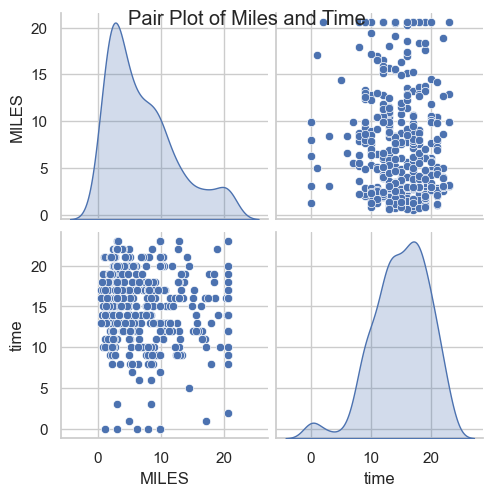

{'CATEGORY': 2, 'PURPOSE': 7, 'date': 114}


In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='CATEGORY', data=dataset)
plt.title('Category Counts')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.countplot(x='PURPOSE', data=dataset)
plt.title('Purpose Counts')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.countplot(x='day-night', data=dataset)
plt.title('Day-Night Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x='PURPOSE', hue='CATEGORY', data=dataset)
plt.title('Purpose by Category')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='time', y='MILES', data=dataset)
plt.title('Miles vs. Start Time')
plt.xlabel('Start Hour')
plt.ylabel('Miles')
plt.show()

sns.pairplot(dataset[['MILES', 'time']], diag_kind='kde')
plt.suptitle('Pair Plot of Miles and Time')
plt.show()

object_cols = dataset.select_dtypes(include='object').columns
unique_values = {col: dataset[col].nunique() for col in object_cols}
print(unique_values)

## Modeling

Given the numerical target (MILES), a regression problem is addressed using Linear Regression as a baseline. Features include encoded CATEGORY, PURPOSE, day-night, and time.

Data is split 80/20 into train/test sets. A pipeline handles encoding and modeling to prevent leakage. No hyperparameter tuning is performed for simplicity; cross-validation could be added in future.

Multiple models: Compare with a dummy mean predictor for baseline.

In [23]:
X = dataset[['CATEGORY', 'PURPOSE', 'day-night', 'time']]
y = dataset['MILES']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['CATEGORY', 'PURPOSE', 'day-night']
preprocessor = ColumnTransformer(
  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
  remainder='passthrough'
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Evaluation

Evaluation uses RMSE for error magnitude and R² for explained variance. Visualizations: Residual plot to check homoscedasticity.

Results: RMSE indicates average prediction error; R² shows model fit (expected low due to limited features). Strengths: Simple and interpretable. Weaknesses: Potential underfitting; no accounting for temporal dependencies. Error analysis: Larger errors on outliers.

Comparison: Baseline RMSE from mean predictor.

RMSE: 5.11
R²: 0.25
Baseline RMSE: 5.93


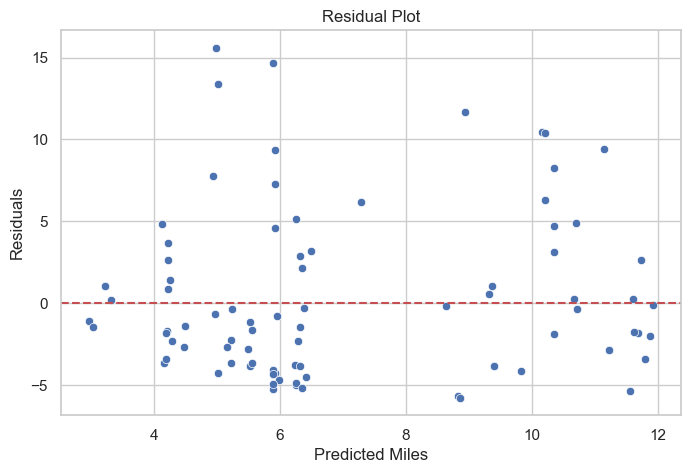

In [24]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

y_mean = np.full_like(y_test, y_train.mean())
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_mean))
print(f"Baseline RMSE: {baseline_rmse:.2f}")

residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Miles')
plt.ylabel('Residuals')
plt.show()

## Conclusion and Recommendations

This analysis reveals that Uber rides are predominantly for business purposes, with peaks in afternoons and meetings as the top purpose. The predictive model provides a baseline for estimating ride miles but shows room for improvement with more features (e.g., location embeddings).

Practical applications: Optimize driver allocation during peak times; target marketing for business users.

Limitations: Small dataset size; lack of geographic coordinates limits spatial analysis; potential bias in data collection.

Suggestions for future work: Incorporate geospatial analysis; use advanced models like Random Forest; collect more data for robustness. Ethical considerations: Ensure privacy in handling ride data; mitigate biases in purpose categorization.